In [19]:
import torch
import torch.nn as nn
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob


from tqdm import tqdm

from utilis import visualize, plot_data
from scipy.io import loadmat


SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [2]:
path = '/home/heye0507/drone/drone_benchmark/data/benchmark'
train_images = path + '/images'
test_images = path + '/test_images'
anno = path + '/annotation'
density_maps = path + '/dmaps'

In [96]:
def get_train_transforms():
    return A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            #A.Resize(360,640,interpolation=2),
            #A.RandomSizedCrop(min_max_height=(409, 512), height=409, width=512, p=1.0),
            #A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=1.0),
        ],
        #additional_targets={'image': 'image','image1': 'image'}
        #keypoint_params = A.KeypointParams(format='xy')
)

def get_train_image_only_transforms():
    return A.Compose(
        [
            #A.Resize(360,640),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.Blur(blur_limit=3,p=0.2),
            A.Normalize(mean=mean,std=std,p=1.0,max_pixel_value=1.0),
            ToTensorV2(p=1.0),
        ],
        additional_targets={'image': 'image'}
    )

def get_valid_trainsforms():
    return A.Compose(
        [
            #A.Resize(360,640,interpolation=2),
            A.Normalize(mean=mean,std=std,p=1.0,max_pixel_value=1.0),
            ToTensorV2(p=1.0),
        ]
    )

# def get_valid_image_only_transforms():
#     return A.Compose(
#         [
#             A.Resize(360,640),
#         ],
#         additional_targets={'image': 'image'}
#     )

mean = torch.tensor([0.3490, 0.3347, 0.3525])
std = torch.tensor([0.1511, 0.1455, 0.1464])

def denormalize(img):
    img = img * std[...,None,None] + mean[...,None,None]
    img = img.permute(1,2,0).cpu().numpy()
    return img

In [209]:
class Counting_Dataset(Dataset):
    def __init__(self,path,image_fnames,dmap_folder,gt_folder=None,transforms=None,mosaic=False,downsample=4):
        '''
            path: root path 
            image_fnames: path of images
            dmap_folder: density map folder, eg: /dmap
            gt_folder: gt folder, currently set to visdrone xml format, modify _get_gt_data() if needed
            transforms: iteratable, can be tuple / list ... etc
            mosaic: mix up image and density map to form a new image, set to false by default
            downsample: resize dmap
        '''
        super().__init__()
        self.path = path
        self.image_fnames = image_fnames
        self.dmap_folder = path + dmap_folder
        self.transforms = transforms
        self.mosaic = mosaic
        self.downsample = downsample
        self.gt_folder = gt_folder # test purpose
        
    def __len__(self):
        return len(self.image_fnames)
    
    def __getitem__(self,idx):
        image_id = self.image_fnames[idx]
        
        if self.mosaic and random.randint(0,1) < 0.5:
            image, density_map, gt_points = self._load_mosaic_image_and_density_map(idx)
        else:
            image, density_map, gt_points = self._load_image_and_density_map(idx)
        
        h,w = image.shape[0]//self.downsample, image.shape[1]//self.downsample
        image = cv2.resize(image,(w, h))
        density_map = cv2.resize(density_map,(w//self.downsample,h//self.downsample))#,interpolation=cv2.INTER_NEAREST)
        
        # Warning: doesn't work for cutout, uncommet transform and make fix code to enable cutout
        # Reason: cutout doesn't apply to mask, so mask must be image. check 01a bottom for code
        if self.transforms:
            for tfms in self.transforms:
                aug = tfms(**{
                    'image': image,
                    'mask': density_map,
                    #'keypoints': gt_points
                })
                #image, density_map, gt_points = aug['image'], aug['mask'], aug['keypoints']
                image, density_map = aug['image'], aug['mask'] # issue with previous keypoints (albumentation?)
        
        
        return image, density_map, image_id, gt_points
        
    
    def _get_dmap_name(self,fn):
        mask_name = fn.split('/')[-1].split('.')[0]
        mask_path = self.dmap_folder + '/' + mask_name + '.npy'
        return mask_path
    
    def _load_image_and_density_map(self,idx):
        image_fname = self.image_fnames[idx]
        dmap_fname = self._get_dmap_name(image_fname)
        image = cv2.imread(image_fname)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB).astype(np.float32)
        image = image/255.
        d_map = np.load(dmap_fname,allow_pickle=True)
        
        #sanity check gt
        _, points = self._get_gt_data(idx)
        # end sanity check
        
        return image, d_map, points
    
    def _load_mosaic_image_and_density_map(self,idx):
        image_1, dmap_1, points_1 = self._load_image_and_density_map(idx)
        while True:
            idx_2 = random.randint(0,len(self.image_fnames)-1)
            if idx != idx_2:
                break
        image_2, dmap_2, points_2 = self._load_image_and_density_map(idx_2)
        
        imsize = min(*image_1.shape[:2])
        xc,yc = [int(random.uniform(imsize*0.4,imsize*0.6)) for _ in range(2)]
        h,w = image_1.shape[0], image_1.shape[1]

        pos = random.randint(0,1)
        if pos == 0: #top left
            x1a,y1a,x2a,y2a = 0,0,xc,yc # img_1
            x1b,y1b,x2b,y2b = w-xc,h-yc,w,h # img_2
        elif pos == 1: # top right
            x1a,y1a,x2a,y2a = w-xc,0,w,yc
            x1b,y1b,x2b,y2b = 0,h-yc,xc,h
        elif pos == 2: # bottom left
            x1a,y1a,x2a,y2a = 0,h-yc,xc,h
            x1b,y1b,x2b,y2b = w-xc,0,w,yc
        elif pos == 3: # bottom right
            x1a,y1a,x2a,y2a = w-xc,h-yc,w,h
            x1b,y1b,x2b,y2b = 0,0,xc,yc
        
        new_image = image_1.copy()
        new_dmap = dmap_1.copy()
        new_image[y1a:y2a,x1a:x2a] = image_2[y1b:y2b,x1b:x2b]
        new_dmap[y1a:y2a,x1a:x2a] = dmap_2[y1b:y2b,x1b:x2b]
        
        #TODO: sanity check to see generate gt
        
        new_gt_points = self._get_mixed_gt_points(points_1,points_2,(x1a,y1a,x2a,y2a),(x1b,y1b,x2b,y2b),(h,w))
        
        return new_image, new_dmap, new_gt_points
    
    '''
    The follow section blocks are for sanity check 
    to compare dmap.sum() with gt points
    remove if needed
    '''
    def _get_mixed_gt_points(self,points_1,points_2,img_1_loc, img_2_loc,img_shape):
#         fn_1, points_1 = self._get_gt_data(idx_1)
#         fn_2, points_2 = self._get_gt_data(idx_2)
        x1a,y1a,x2a,y2a = img_1_loc
        x1b,y1b,x2b,y2b = img_2_loc
        h,w = img_shape
        
        result_boxes = []
        result_boxes.append(points_2)
        result_boxes = np.concatenate(result_boxes,0)
        padw = x1a-x1b
        pady = y1a-y1b

        result_boxes[:,0] += padw
        result_boxes[:,1] += pady

        np.clip(result_boxes[:,0],0,w,out=result_boxes[:,0])
        np.clip(result_boxes[:,1],0,h,out=result_boxes[:,1])
        result_boxes = result_boxes.astype(np.int32)

        result_boxes = result_boxes[np.where(result_boxes[:,0] * result_boxes[:,1] > 0)]
        result_boxes = result_boxes[np.where(result_boxes[:,0] < w)]
        result_boxes = result_boxes[np.where(result_boxes[:,1] < h)]
        
        boxes = []
        for (x,y) in points_1:
            if x >= x1a and x <= x2a and y >= y1a and y <= y2a:
                continue
            else:
                boxes.append((x,y))
        if len(boxes) == 0:
            return result_boxes
        return np.concatenate((boxes, result_boxes),axis=0)
    
    def _get_gt_data(self,idx):
        if not self.gt_folder:
            return (None,0)
        fn = self.image_fnames[idx]
        anno_path = self.path + self.gt_folder + '/' + fn.split('/')[-1].split('.')[0] + '.mat'
        test_data = loadmat(anno_path)
        points = test_data['annotation'].astype(int)
        return fn, points

In [98]:
train_fp = glob(train_images + '/*.jpg')
test_fp = glob(test_images + '/*.jpg')

In [210]:
train_dataset = Counting_Dataset(path=path,
                                 image_fnames=train_fp,dmap_folder='/dmaps',
                                 gt_folder='/annotation/all',
                                 transforms=[get_train_transforms(),get_train_image_only_transforms()],
                                 mosaic=True,
                                 downsample=2
                                )

valid_dataset = Counting_Dataset(path=path,
                                 image_fnames=test_fp,dmap_folder='/dmaps',
                                 gt_folder='/annotation/all',
                                 transforms=[get_valid_trainsforms()],
                                 downsample=2
                                )

In [214]:
img, dmap, fn, points = valid_dataset[2000]

tensor(31.1962)


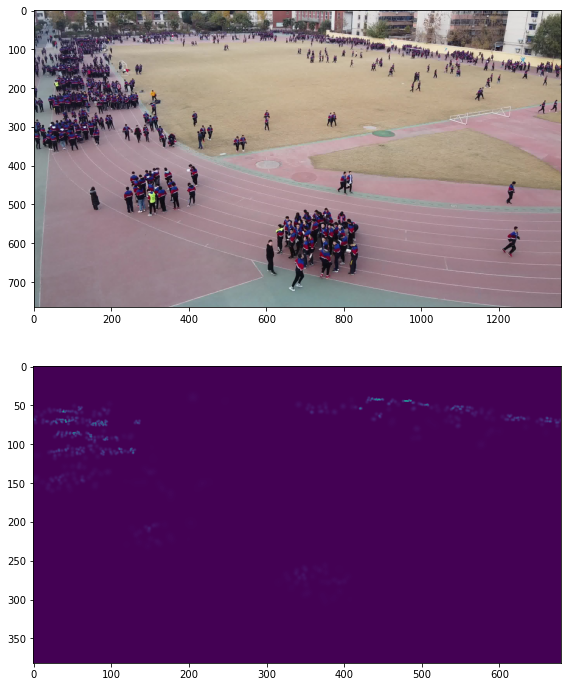

In [215]:
visualize(denormalize(img),dmap)

In [216]:
len(points), dmap.sum() * 4 * 4

(502, tensor(499.1392))

In [123]:
def collate_fn(batch):
    imgs, dmaps, fns, gt_points = zip(*batch)
    imgs = torch.stack(imgs)
    dmaps = torch.stack(dmaps).unsqueeze(1)
    return imgs,dmaps,fns,gt_points

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=TrainGlobalConfig.batch_size,
    sampler=RandomSampler(train_dataset),
    pin_memory=False,
    drop_last=True,
    num_workers=TrainGlobalConfig.num_workers,
    collate_fn=collate_fn,
)

val_loader = torch.utils.data.DataLoader(
    valid_dataset, 
    batch_size=TrainGlobalConfig.batch_size,
    num_workers=TrainGlobalConfig.num_workers,
    shuffle=False,
    sampler=SequentialSampler(valid_dataset),
    pin_memory=False,
    collate_fn=collate_fn,
)

In [124]:
imgs, dmaps, fns, points = next(iter(val_loader))

In [125]:
imgs.shape

torch.Size([32, 3, 382, 680])

In [140]:
net.eval()
preds = net(imgs)

In [167]:
preds.shape

torch.Size([32, 1, 95, 170])

In [168]:
preds[0].shape

torch.Size([1, 95, 170])

In [149]:
dmaps[0].sum() * 16,len(points[0])

(tensor(410.4282), 412)

In [118]:
class TrainGlobalConfig:
    num_workers = 4
    batch_size = 32
    n_epochs = 40 # n_epochs = 40
    lr = 0.0002

    folder = 'test_delete'

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = True  # do scheduler.step after optimizer.step
    validation_scheduler = False  # do scheduler.step after validation stage loss

    SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
    scheduler_params = dict(
        max_lr=1e-3,
        #total_steps = len(train_dataset) // 4 * n_epochs, # gradient accumulation
        epochs=n_epochs,
        steps_per_epoch=int(len(train_dataset) / batch_size),
        pct_start=0.3,
        anneal_strategy='cos', 
        final_div_factor=10**5
    )
    
#     SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
#     scheduler_params = dict(
#         mode='min',
#         factor=0.5,
#         patience=1,
#         verbose=False, 
#         threshold=0.0001,
#         threshold_mode='abs',
#         cooldown=0, 
#         min_lr=1e-8,
#         eps=1e-08
#     )

# Model

In [119]:
'''
    credit: https://github.com/CommissarMa/MCNN-pytorch/blob/master/mcnn_model.py
'''

class MCNN(nn.Module):
    '''
    Implementation of Multi-column CNN for crowd counting
    '''
    def __init__(self,load_weights=False):
        super(MCNN,self).__init__()

        self.branch1=nn.Sequential(
            nn.Conv2d(3,16,9,padding=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(16,32,7,padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32,16,7,padding=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(16,8,7,padding=3),
            nn.ReLU(inplace=True)
        )

        self.branch2=nn.Sequential(
            nn.Conv2d(3,20,7,padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(20,40,5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(40,20,5,padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(20,10,5,padding=2),
            nn.ReLU(inplace=True)
        )

        self.branch3=nn.Sequential(
            nn.Conv2d(3,24,5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(24,48,3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(48,24,3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(24,12,3,padding=1),
            nn.ReLU(inplace=True)
        )

        self.fuse=nn.Sequential(nn.Conv2d(30,1,1,padding=0))

        if not load_weights:
            self._initialize_weights()

    def forward(self,img_tensor):
        x1=self.branch1(img_tensor)
        x2=self.branch2(img_tensor)
        x3=self.branch3(img_tensor)
        x=torch.cat((x1,x2,x3),1)
        x=self.fuse(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [120]:
net = MCNN()

# Train Loop

In [121]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        

In [122]:
import warnings
warnings.filterwarnings("ignore")

#opt_level ='O1' # apex

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'/home/heye0507/drone/drone_benchmark/model/{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        
        #self.model, self.optimizer = amp.initialize(self.model,self.optimizer,opt_level=opt_level) # apex
        self.scaler = torch.cuda.amp.GradScaler()
        
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.criterion = MSELoss_MCNN
        self.metric = MAELoss_MCNN
        self.log(f'Fitter prepared. Device is {self.device}')
        
        # self.iters_to_accumulate = 4 # gradient accumulation

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss, mae_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, mse_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, mae_loss: {mae_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss, mae_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, mae_loss: {mae_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        mae_loss = AverageMeter()
        t = time.time()
        for step, (images, density_maps, fns, gt_pts) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'mse_loss: {summary_loss.avg:.5f}, ' + \
                        f'mae_loss: {mae_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                density_maps = density_maps.to(self.device).float()
                

                preds = self.model(images)
                loss = self.criterion(preds,density_maps)
                metric_loss = self.metric(preds,density_maps,4)
                mae_loss.update(metric_loss.detach().item(),batch_size)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss, mae_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        mae_loss = AverageMeter()
        t = time.time()
        for step, (images, density_maps, fns, gt_pts) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'mse_loss: {summary_loss.avg:.5f}, ' + \
                        f'mae_loss: {mae_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            density_maps = density_maps.to(self.device).float()
            
            
            self.optimizer.zero_grad()
            
            with torch.cuda.amp.autocast(): #native fp16
                preds = self.model(images)
                loss = self.criterion(preds,density_maps)
            self.scaler.scale(loss).backward()
            
            # loss = loss / self.iters_to_accumulate # gradient accumulation
            
#             with amp.scale_loss(loss,self.optimizer) as scaled_loss: # apex
#                 scaled_loss.backward()
            #loss.backward()

            metric_loss = self.metric(preds,density_maps,4)
            mae_loss.update(metric_loss.detach().item(),batch_size)
            summary_loss.update(loss.detach().item(), batch_size)
            
            #self.optimizer.step()
            self.scaler.step(self.optimizer) # native fp16
            
            if self.config.step_scheduler:
                self.scheduler.step()
            
            self.scaler.update() #native fp16
                
                
#             if (step+1) % self.iters_to_accumulate == 0: # gradient accumulation

#                 self.optimizer.step()
#                 self.optimizer.zero_grad()

#                 if self.config.step_scheduler:
#                     self.scheduler.step()
                    
            if step == 20:
                break

        return summary_loss, mae_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
            #'amp': amp.state_dict() # apex
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')